# Face ID

### Imports

In [2]:
import os
import time
import uuid # create unique, uniform identifiers
import cv2 # computer vision
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import math as m 
import random
import shutil
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model


### Collecting images using OpenCV

In [8]:
IMAGES_PATH = os.path.join('Data', 'Images')
num_images = 30

cap = cv2.VideoCapture(0) # mac camera number = 1
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)


for img_num in range(num_images):
    print('Collecting image {}'.format(img_num))
    ret, frame = cap.read()
    img_name = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5) # Remember to take samples with face out of the picture (negative samples are important for classifier component of deep learning model)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)


[ WARN:0@240.765] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


1   HIToolbox                           0x00000001a606f90c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x00000001a6087214 SetMenuBarObscured + 120
3   HIToolbox                           0x00000001a608e390 _ZN13HIApplication11FrontUILostEv + 44
4   HIToolbox                           0x00000001a608704c _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 528
5   HIToolbox                           0x00000001a6080f70 _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 204
6   HIToolbox                           0x00000001a6047cd0 _NotifyEventLoopObservers + 176
7   HIToolbox                           0x00000001a608096c AcquireEventFromQueue + 432
8   HIToolbox                           0x00000001a606fc84 ReceiveNextEventCommon + 320
9   HIToolbox                           0x00000001a606fb2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
10  AppKit                              0x000000019fc1584c _DPSNextEv

1   HIToolbox                           0x00000001a60e45c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x00000001a608727c SetMenuBarObscured + 224
3   HIToolbox                           0x00000001a6086ee8 _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 172
4   HIToolbox                           0x00000001a6080fcc _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 296
5   HIToolbox                           0x00000001a6047cd0 _NotifyEventLoopObservers + 176
6   HIToolbox                           0x00000001a608096c AcquireEventFromQueue + 432
7   HIToolbox                           0x00000001a606fc84 ReceiveNextEventCommon + 320
8   HIToolbox                           0x00000001a606fb2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
9   AppKit                              0x000000019fc1584c _DPSNextEvent + 632
10  AppKit                              0x000000019fc149dc -[NSApplication(NSEvent) _ne

-1

Use labelme to create labels for the face in each image. If a face is not in the picture, no label will be created.

Open images directory: `Data/Images/`

Change the output directory to `Data/Labels/` by going to File > Change Output Directory.

Next, go to File > Save Automatically.

Draw Rectangles on Pictures : 

Go to Edit > Draw Rectangle and draw a rectangle on each face in the picture. 

Hit `D` to go to the next picture.

In [9]:
!labelme

1   HIToolbox                           0x00000001a620ad4c _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 284
2   HIToolbox                           0x00000001a60e4230 _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 40
3   HIToolbox                           0x00000001a60e4184 _ZN15MenuBarInstance14EnableAutoShowEv + 56
4   HIToolbox                           0x00000001a6087310 SetMenuBarObscured + 372
5   HIToolbox                           0x00000001a6086ee8 _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 172
6   HIToolbox                           0x00000001a6080fcc _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 296
7   HIToolbox                           0x00000001a6047cd0 _NotifyEventLoopObservers + 176
8   HIToolbox                           0x00000001a608096c AcquireEventFromQueue + 432
9   HIToolbox                           0x00000001a606fe0c ReceiveNextEventCommon + 712
10  HIToolbox                           0x00000001a606fb2c

### Review Dataset and Build Image Loading Function

In [10]:
"""
Limit GPU Memory Growth // good practice when using tensorflow to prevent out of memory errors

Essentially grabbing all gpu's and setting memory growth to true

Avoids OOM errors by setting GPU Memory Consumption Growth
"""
num_gpus = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    num_gpus += 1
    tf.config.experimental.set_memory_growth(gpu, True)

print(f"There are {num_gpus} GPUs on this machine")



There are 1 GPUs on this machine


In [11]:
# tf.test.is_gpu_available() # Deprecated
tf.config.list_physical_devices('GPU') # Confirms GPU is available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load images into TF data pipeline

In [31]:
images = tf.data.Dataset.list_files('Data/Images/*.jpg', shuffle = False) # /*.jpg is a wildcard search

In [32]:
images.as_numpy_iterator().next() # Verify images is working

b'Data/Images/0335bfc6-fe85-11ed-80b5-96638e63c65a.jpg'

In [33]:
# Loading images
def load_image(img_file):
    byte_img = tf.io.read_file(img_file)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [34]:
images = images.map(load_image)

In [35]:
images.as_numpy_iterator().next()

array([[[133, 119,  84],
        [116, 102,  67],
        [113,  98,  67],
        ...,
        [169, 157, 141],
        [173, 161, 147],
        [164, 152, 138]],

       [[129, 114,  81],
        [127, 112,  79],
        [114,  99,  68],
        ...,
        [164, 152, 136],
        [169, 157, 143],
        [170, 158, 144]],

       [[121, 106,  75],
        [129, 114,  83],
        [127, 112,  81],
        ...,
        [166, 154, 138],
        [169, 157, 143],
        [173, 161, 147]],

       ...,

       [[107,  80,  37],
        [102,  75,  32],
        [111,  83,  43],
        ...,
        [148, 207, 241],
        [149, 208, 242],
        [148, 207, 241]],

       [[111,  84,  39],
        [106,  79,  34],
        [109,  82,  39],
        ...,
        [144, 209, 241],
        [148, 213, 245],
        [150, 215, 247]],

       [[ 95,  68,  23],
        [ 95,  68,  23],
        [101,  74,  31],
        ...,
        [143, 212, 245],
        [147, 213, 245],
        [148, 214, 246]]

In [17]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### View Raw Images with Matplotlib

In [36]:
image_generator = images.batch(4).as_numpy_iterator()

In [37]:
plot_images = image_generator.next()

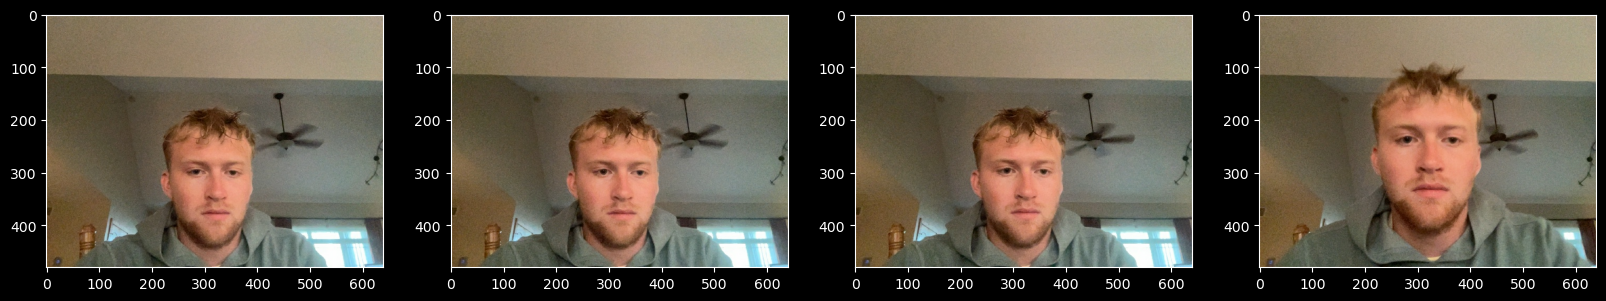

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [39]:
len(os.listdir("Data/Images/")), len(os.listdir('Data/Labels/'))

(202, 195)

### Partition Unaugmented Data

In [41]:
img_count = len(os.listdir("Data/Images/"))

train = m.floor(img_count * 0.7)
test = m.ceil(img_count * 0.15)
validation = m.floor(img_count * 0.15)
print(f"train = {train}\ntest = {test}\nvalidation = {validation}\n")
total = train + test + validation
print(f'total = {total}')

train = 141
test = 31
validation = 30

total = 202


In [42]:
# Moving Image Files

all_images = "Data/Images/"
test_images = "Data/Test/Images/"
train_images = "Data/Train/Images/"
validation_images = "Data/Validation/Images/"

files = os.listdir(all_images)
num_files = len(files)

random.shuffle(files)

num_train_files = m.floor(num_files * 0.7)
num_test_files = m.ceil(num_files * 0.15)
# num_validatation_files = m.floor(num_files * 0.15)

train_files = files[:num_train_files]
test_files = files[num_train_files:num_train_files + num_test_files]
validation_files = files[num_train_files + num_test_files:]

for file in test_files:
    source = os.path.join(all_images, file)
    destination = os.path.join(test_images, file)
    shutil.copy(source, destination)

for file in train_files:
    source = os.path.join(all_images, file)
    destination = os.path.join(train_images, file)
    shutil.copy(source, destination)

for file in validation_files:
    source = os.path.join(all_images, file)
    destination = os.path.join(validation_images, file)
    shutil.copy(source, destination)

In [43]:
# Moving Label files

for dir in ['Train', 'Test', 'Validation']:
    for file in os.listdir(os.path.join("Data", dir, "Images")):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join("Data", "Labels", filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', dir, 'labels', filename)
            os.replace(existing_filepath, new_filepath)


### Apply Image Augmentation on Images and Labels using Albumentations

In [45]:
img = cv2.imread(os.path.join("Data", "Train", "Images",
                 "0a89fb7a-fe85-11ed-80b5-96638e63c65a.jpg"))

img.shape# == (480, 640, 3) # (height, width, channels)
# Idea : Delete all pictures with 1920, 1080 size 

(480, 640, 3)

In [34]:
# augmentor = alb.Compose([alb.RandomCrop(width=1920, height=1080),
#                          alb.HorizontalFlip(p=0.5),
#                          alb.RandomBrightnessContrast(p=0.2),
#                          alb.RandomGamma(p=0.2),
#                          alb.RGBShift(p=0.2),
#                          alb.VerticalFlip(p=0.5)],
#                         bbox_params=alb.BboxParams(format='albumentations',
#                                                    label_fields=['class_labels']))


In [46]:
augmentor = alb.Compose([alb.RandomCrop(width=640, height=480),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))


### Load and Test Image and Annotation with OpenCV and JSON

In [47]:


with open(os.path.join('Data', 'Train', 'Labels', '0a89fb7a-fe85-11ed-80b5-96638e63c65a.json'), 'r') as f:
    label = json.load(f)


In [48]:
label['shapes'][0]['points']

[[263.030303030303, 241.21212121212122],
 [378.78787878787875, 379.3939393939394]]

### Extract Coordinates and Rescale to Match Image Resolution

In [49]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [57]:
#coords = list(np.divide(coords, [1920, 1080, 1920, 1080])) # [width, height, width, height]
#coords

[0.000336570623088685,
 0.0004872968342960698,
 0.00037838063837920485,
 0.0006217967776645147]

In [50]:
coords = list(np.divide(coords, [640, 480, 640, 480]))
coords

[0.41098484848484845,
 0.5025252525252525,
 0.5918560606060606,
 0.7904040404040403]

### Apply Augmentations and View Results

In [52]:
augmented = augmentor(image=img, bboxes = [coords], class_labels = ['face'])

In [74]:
#augmented['image']
#augmented['bboxes']
img.shape

(480, 640, 3)

In [53]:
# cv2.rectangle(augmented['image'],
#               tuple(np.multiply(augmented['bboxes']
#                     [0][:2], [1920, 1080]).astype(int)),
#               tuple(np.multiply(augmented['bboxes']
#                     [0][2:], [1920, 1080]).astype(int)),
#               (255, 0, 0), 2)

# plt.imshow(augmented['image'])

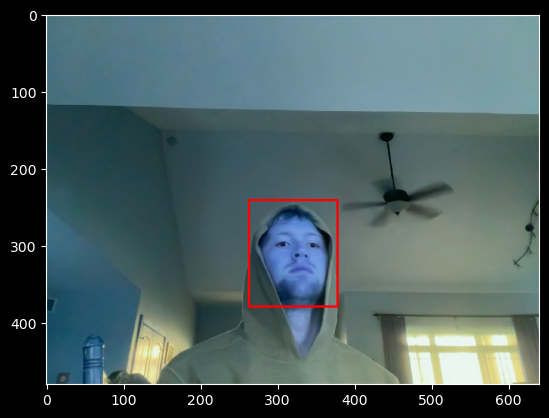

In [54]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes']
                    [0][:2], [640, 480]).astype(int)),
              tuple(np.multiply(augmented['bboxes']
                    [0][2:], [640, 480]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])


### Build and Run Augmentation Pipeline

In [56]:
#for partition in ['Train', 'Test', 'Validation']:
for partition in os.listdir("/Users/rileyoest/VS_Code/In_Progress/FaceID/Data"):
    if partition != "Images" and partition != "Labels":
        for image in os.listdir(os.path.join('Data', partition, 'Images')):
            img = cv2.imread(os.path.join('Data', partition, 'Images', image))
        
            coords = [0, 0, 0.00001, 0.00001] # Default coordinates for negative samples
            label_path = os.path.join(
                'Data', partition, 'Labels', f'{image.split(".")[0]}.json')
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)

                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [640, 480, 640, 480]))

            try:
                for x in range(60):
                    augmented = augmentor(
                        image=img, bboxes=[coords], class_labels=['face'])
                    cv2.imwrite(os.path.join('Augmented_Data', partition, 'Images',
                                f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                    annotation = {}
                    annotation['Image'] = image

                    if os.path.exists(label_path):
                        if len(augmented['bboxes']) == 0:
                            annotation['bbox'] = [0, 0, 0, 0]
                            annotation['class'] = 0
                        else:
                            annotation['bbox'] = augmented['bboxes'][0]
                            annotation['class'] = 1
                    else:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0

                    with open(os.path.join('Augmented_Data', partition, 'Labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                        json.dump(annotation, f)

            except Exception as e:
                print(f"Exception: {e}")


Exception: image must be numpy array type
Exception: image must be numpy array type
Exception: image must be numpy array type


### Load Augmented Images to Tensorflow Dataset

In [57]:
def resize_image(image):
    return tf.image.resize(image, (120, 120))


def normalize_image(image):
    return image / 255.0


train_images = tf.data.Dataset.list_files(
    'Augmented_Data/Train/Images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(resize_image)
train_images = train_images.map(normalize_image)

test_images = tf.data.Dataset.list_files(
    'Augmented_Data/Test/Images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(resize_image)
test_images = test_images.map(normalize_image)

validation_images = tf.data.Dataset.list_files(
    'Augmented_Data/Validation/Images/*.jpg', shuffle=False)
validation_images = validation_images.map(load_image)
validation_images = validation_images.map(resize_image)
validation_images = validation_images.map(normalize_image)


In [58]:
train_images.as_numpy_iterator().next()

array([[[0.32843137, 0.20130719, 0.05686275],
        [0.3019608 , 0.18235295, 0.02058824],
        [0.26568624, 0.1715686 , 0.02908495],
        ...,
        [0.52320236, 0.8467317 , 0.97026116],
        [0.48137254, 0.82254905, 0.95098037],
        [0.49934655, 0.82712424, 0.9535946 ]],

       [[0.36111113, 0.24477123, 0.06830066],
        [0.31862745, 0.20196079, 0.03627451],
        [0.27810457, 0.18071893, 0.05588235],
        ...,
        [0.38300613, 0.5415031 , 0.6143787 ],
        [0.33431372, 0.5245098 , 0.5892157 ],
        [0.32026175, 0.46666667, 0.53627425]],

       [[0.35326797, 0.24346405, 0.05522876],
        [0.31862745, 0.20490196, 0.03431373],
        [0.28398693, 0.18202613, 0.04738562],
        ...,
        [0.404575  , 0.5418299 , 0.61307156],
        [0.34215686, 0.49509802, 0.54607844],
        [0.29640514, 0.40751594, 0.457189  ]],

       ...,

       [[0.44411764, 0.36764705, 0.2382353 ],
        [0.45490196, 0.38039216, 0.24803922],
        [0.36372548, 0

### Prepare Labels

In [59]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']


In [60]:
# Loading labels to tensorflow dataset

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']


train_labels = tf.data.Dataset.list_files(
    'Augmented_Data/Train/Labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(
    load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files(
    'Augmented_Data/Test/Labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(
    load_labels, [x], [tf.uint8, tf.float16]))

validation_labels = tf.data.Dataset.list_files(
    'Augmented_Data/Validation/Labels/*.json', shuffle=False)
validation_labels = validation_labels.map(lambda x: tf.py_function(
    load_labels, [x], [tf.uint8, tf.float16]))

#train_labels.as_numpy_iterator.next()
next(iter(train_labels))


(<tf.Tensor: shape=(1,), dtype=uint8, numpy=array([1], dtype=uint8)>,
 <tf.Tensor: shape=(4,), dtype=float16, numpy=array([0.3333 , 0.06946, 0.661  , 0.64   ], dtype=float16)>)

### Combine Label and Image Samples

In [61]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(validation_images), len(validation_labels)


(8400, 8400, 1860, 1860, 1800, 1800)

In [62]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(8000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(3000)
test = test.batch(8)
test = test.prefetch(4)

validation = tf.data.Dataset.zip((validation_images, validation_labels))
validation = validation.shuffle(3000)
validation = validation.batch(8)
validation = validation.prefetch(4)


In [63]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.429   , 0.1818  , 0.7266  , 0.803   ],
        [0.643   , 0.5366  , 0.864   , 0.851   ],
        [0.3835  , 0.1439  , 0.715   , 0.765   ],
        [0.001562, 0.546   , 0.0985  , 0.804   ],
        [0.4365  , 0.1477  , 0.6987  , 0.683   ],
        [0.1761  , 0.002525, 0.8315  , 0.992   ],
        [0.359   , 0.3977  , 0.6675  , 0.9204  ],
        [0.      , 0.      , 0.      , 0.      ]], dtype=float16))

### View Images and Annotations

In [64]:
data_samples = train.as_numpy_iterator()

In [65]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


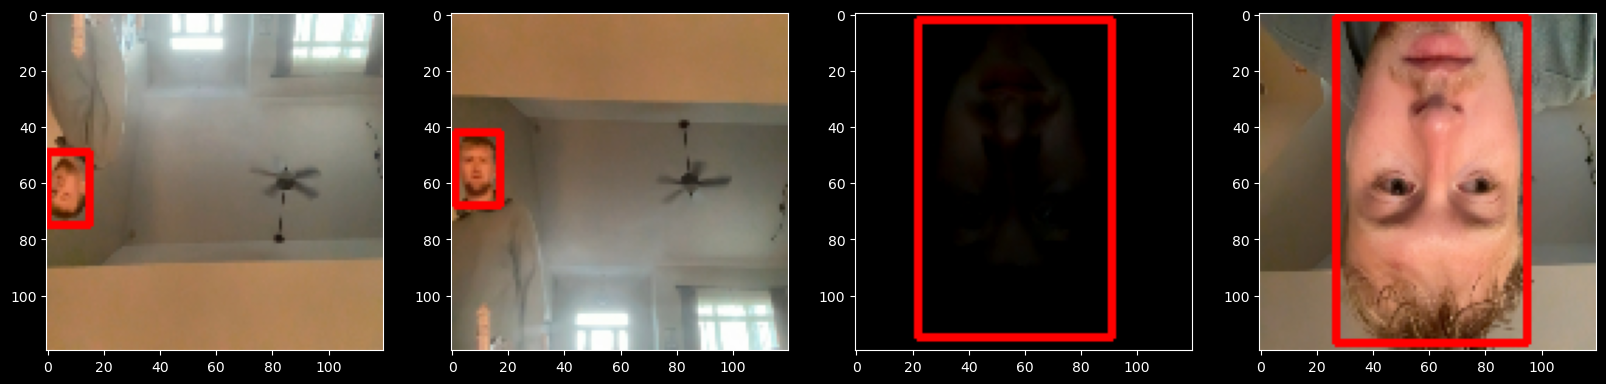

In [66]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [
                        120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [
                        120, 120]).astype(int)),
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)


### Build Deep Learning using the Functional API

In [67]:
vgg = VGG16(include_top = False)

In [68]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build Network

In [69]:
def build_model():
    input_layer = Input(shape=(120, 120, 3)) 

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker


### Testing the Neural Network

In [70]:
facetracker = build_model()

In [71]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [72]:
X, y = train.as_numpy_iterator().next()

In [73]:
X.shape

(8, 120, 120, 3)

In [74]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 257ms/step


In [75]:
classes, coords

(array([[0.44813898],
        [0.36376882],
        [0.47864664],
        [0.3494928 ],
        [0.43199313],
        [0.43994546],
        [0.35190237],
        [0.43352965]], dtype=float32),
 array([[0.5122837 , 0.55963254, 0.50088567, 0.59847486],
        [0.5029057 , 0.5263216 , 0.52842534, 0.5546902 ],
        [0.5176431 , 0.3552041 , 0.54734594, 0.48987353],
        [0.49253026, 0.5499986 , 0.53777575, 0.5013188 ],
        [0.5303896 , 0.40190417, 0.60731167, 0.50318897],
        [0.51479113, 0.53185546, 0.42392358, 0.5790894 ],
        [0.47212908, 0.5832645 , 0.49738553, 0.62924564],
        [0.5278815 , 0.39194718, 0.61126596, 0.5022636 ]], dtype=float32))

### Define Losses and Optimizers

In [76]:
len(train)

1050

In [77]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [78]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001, decay = lr_decay)

In [79]:
"""
Localization and Classification Loss
"""

def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(
        tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [80]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [81]:
# Testing

localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.8537679>

In [82]:
classloss(y[0], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.66486996>

### Training the Neural Network

In [83]:
class FaceTracker(Model):
    # __init__ method for passing parameters
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    # compile method for passing classification loss and localization loss
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt


    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(
                tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables)) # Gradient Descent

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    # call method for .predict function
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [84]:
model = FaceTracker(facetracker)

In [85]:
model.compile(opt, classloss, regressloss)

In [86]:
logdir = 'logs'

In [87]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [88]:
hist = model.fit(train, epochs = 7, validation_data = validation, callbacks = [tensorboard_callback], use_multiprocessing = True)

Epoch 1/7
1050/1050 [==============================] - 101s 86ms/step - total_loss: 0.1599 - class_loss: 0.0480 - regress_loss: 0.1359 - val_total_loss: 0.0358 - val_class_loss: 2.0204e-04 - val_regress_loss: 0.0357
Epoch 2/7
1050/1050 [==============================] - 99s 86ms/step - total_loss: 0.0580 - class_loss: 0.0209 - regress_loss: 0.0476 - val_total_loss: 0.0191 - val_class_loss: 5.8650e-04 - val_regress_loss: 0.0188
Epoch 3/7
1050/1050 [==============================] - 99s 86ms/step - total_loss: 0.0385 - class_loss: 0.0131 - regress_loss: 0.0320 - val_total_loss: 0.0083 - val_class_loss: 5.4463e-05 - val_regress_loss: 0.0083
Epoch 4/7
1050/1050 [==============================] - 100s 86ms/step - total_loss: 0.0280 - class_loss: 0.0106 - regress_loss: 0.0227 - val_total_loss: 0.0225 - val_class_loss: 0.0018 - val_regress_loss: 0.0217
Epoch 5/7
1050/1050 [==============================] - 99s 86ms/step - total_loss: 0.0263 - class_loss: 0.0101 - regress_loss: 0.0212 - val_to

Ideally we want `val_regress_loss` and `class_loss` to decrease at a consistent rate. Any drastic changes of these two values during the epochs is not good, they should be smoothly changing.

In [89]:
hist.history

{'total_loss': [0.24928373098373413,
  0.18196827173233032,
  0.013470043428242207,
  0.00833274144679308,
  0.002417522482573986,
  0.0026007520500570536,
  0.025388086214661598],
 'class_loss': [0.10708396881818771,
  0.0838208869099617,
  8.090469054877758e-05,
  2.478887381585082e-06,
  0.0002213130210293457,
  2.9106271540513262e-05,
  1.4253603239922086e-06],
 'regress_loss': [0.19574174284934998,
  0.14005783200263977,
  0.013429591432213783,
  0.008331501856446266,
  0.002306865993887186,
  0.0025861989706754684,
  0.025387372821569443],
 'val_total_loss': [0.03578510135412216,
  0.019122088328003883,
  0.008305419236421585,
  0.022547325119376183,
  0.03184085339307785,
  0.027922390028834343,
  0.04215896129608154],
 'val_class_loss': [0.00020203966414555907,
  0.0005865047569386661,
  5.446322393254377e-05,
  0.00176391436252743,
  0.0005293974536471069,
  0.001086909556761384,
  0.0007143430411815643],
 'val_regress_loss': [0.03568408265709877,
  0.01882883533835411,
  0.00

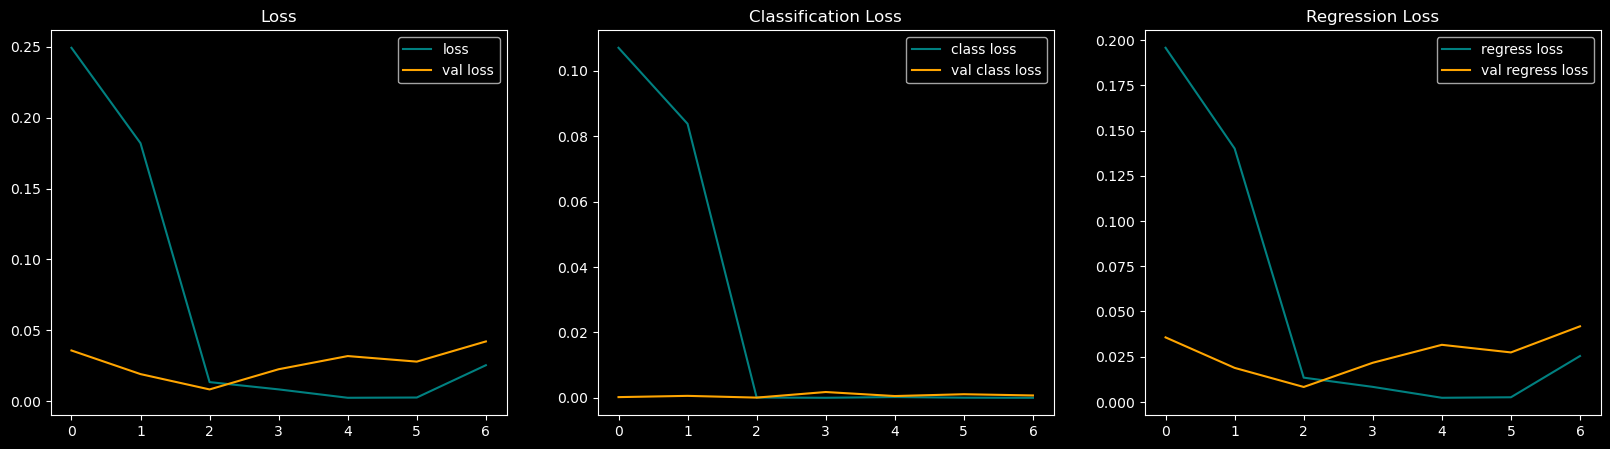

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'],
           color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'],
           color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()


### Make Predictions

In [91]:
test_data = test.as_numpy_iterator()

In [92]:
test_sample = test_data.next()

In [93]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


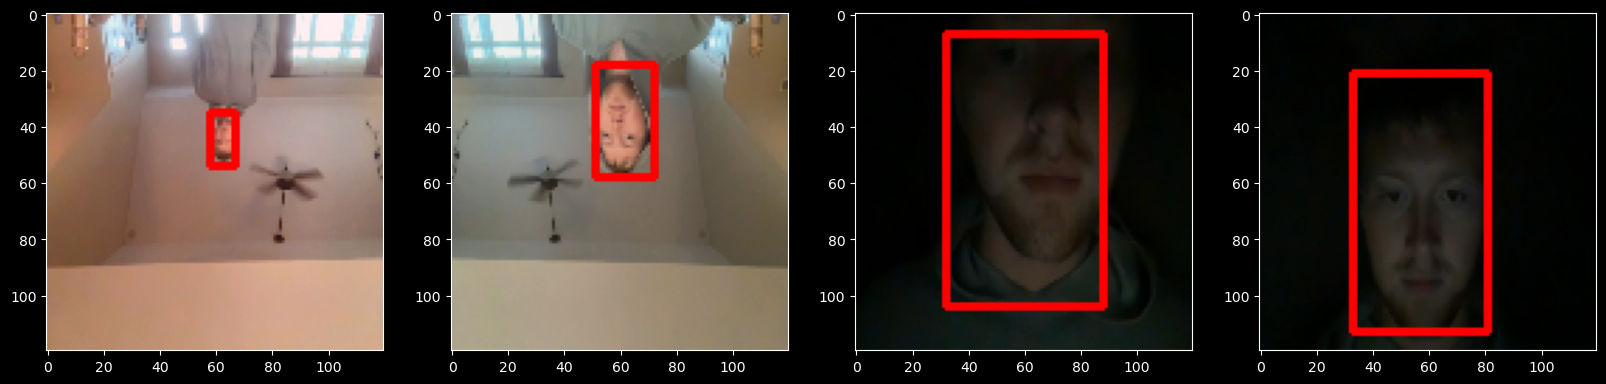

In [94]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [
                            120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [
                            120, 120]).astype(int)),
                      (255, 0, 0), 2)

    ax[idx].imshow(sample_image)


### Save Model

In [95]:
facetracker.save('facetracker.h5')

In [3]:
facetracker = load_model('facetracker.h5')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



### Real Time Detection

In [4]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
while cap.isOpened():
    _, frame = cap.read()
  
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized/255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
    
        # Controls the main rectangle
        cv2.rectangle(frame,
                        tuple(np.multiply(sample_coords[:2], [
                            640, 480]).astype(int)),
                        tuple(np.multiply(sample_coords[2:], [
                            640, 480]).astype(int)),
                    (255, 0, 0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                        tuple(np.add(np.multiply(sample_coords[:2], [640, 480]).astype(int),
                                [0, -30])),
                        tuple(np.add(np.multiply(sample_coords[:2], [640, 480]).astype(int),
                                [80, 0])),
                    (255, 0, 0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [640, 480]).astype(int),
                                                [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


[ WARN:0@9.853] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
2023-05-30 09:21:38.231163: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 14ms/step


1   HIToolbox                           0x00000001a60e45c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x00000001a60e4188 _ZN15MenuBarInstance14EnableAutoShowEv + 60
3   HIToolbox                           0x00000001a6087310 SetMenuBarObscured + 372
4   HIToolbox                           0x00000001a6086ee8 _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 172
5   HIToolbox                           0x00000001a6080fcc _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 296
6   HIToolbox                           0x00000001a6047cd0 _NotifyEventLoopObservers + 176
7   HIToolbox                           0x00000001a608096c AcquireEventFromQueue + 432
8   HIToolbox                           0x00000001a606fc84 ReceiveNextEventCommon + 320
9   HIToolbox                           0x00000001a606fb2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
10  AppKit                              0x000000019fc1584c _DPS

1/1 [==============================] - 0s 13ms/step


1   HIToolbox                           0x00000001a620ad4c _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 284
2   HIToolbox                           0x00000001a60e4230 _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 40
3   HIToolbox                           0x00000001a605130c _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 72
4   HIToolbox                           0x00000001a60e48a0 _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 216
5   HIToolbox                           0x00000001a6047cd0 _NotifyEventLoopObservers + 176
6   HIToolbox                           0x00000001a607bbb0 PostEventToQueueInternal + 696
7   HIToolbox                           0x00000001a607d340 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 460
8   HIToolbox                           0x00000001a6089c28 _ZL15Convert1CGEventh + 264
9   HIToolbox                           0x00000001a6089ab0 _ZL16MainLoopObserverjP14OpaqueEventRefPv + 56
10  HITo

1/1 [==============================] - 0s 13ms/step


KeyboardInterrupt: 

: 